In [1]:
import math
import re
import sqlite3
import time
import pandas as pd
pd.set_option('display.max_columns', None)
from datetime import datetime, timedelta
#import plotly.graph_objects as go
#import plotly.express as px
from bs4 import BeautifulSoup as bs4
from selenium.webdriver import Chrome
from selenium import webdriver
from selenium.webdriver.common.by import By

from sqlalchemy import MetaData, text, Column, Integer, String, ForeignKey, Table, create_engine, Float, Boolean, DateTime
from sqlalchemy.orm import relationship, backref, sessionmaker
from sqlalchemy.ext.declarative import declarative_base

meta = MetaData()

# Create an Engine object
engine = create_engine('sqlite:///fantasy_data.db', echo=False)

# Connect to the database
connection = engine.raw_connection()

# Add the custom function to the SQLite database
#connection.create_function("sqrt", 1, math.sqrt)

#conn = sqlite3.connect('fantasy_data.db')
#conn.create_function('sqrt', 1, math.sqrt)

#from optimize_lineup import Optimized_Lineups
from fantasy_utils import Fantasy_Projections as fp
import fantasy_utils as fu
fp = fu.Fantasy_Projections()

from scraper import Scraper
s = Scraper()

In [2]:
def login():
    driver = webdriver.Chrome("C:\\ProgramData\\Anaconda3\\WebDriver\\bin\\chromedriver.exe")
    driver.get('https://www.cbssports.com/login?master_product=150&xurl=https%3A%2F%2Fwww.cbssports.com%2Flogin')
    #search_box = driver.find_element_by_id('name')
    #search_box.send_keys('gostros09')
    #search_box = driver.find_element_by_id('password')
    #search_box.send_keys('Segneri9A')
    #search_box.submit()
    return driver

In [3]:
def stitch_positions(row):
    pos_code = row[position_priority+['P']]>=5
    return list(pos_code[pos_code].index)

In [4]:
def get_cbs_projections_ros(driver, url):
    #driver.implicitly_wait(10)
    driver.get(url)
    html = driver.page_source
    soup = bs4(html, 'html5lib')
    data = pd.read_html(str(soup.find_all('table')))[0]
    data.columns = data.columns.droplevel()
    data['cbsid'] = data.Action.apply(lambda txt: -1 if len(re.findall(r'\b\d{5,}\b', txt))==0 else re.findall(r'\b\d{5,}\b', txt)[0])
    data['cbsid'] = data.cbsid.astype(int)
    data['owner_id'] = data.Action.apply(lambda txt: re.findall(r'"onTeamId":"(\d+)"', txt)[0] if len(re.findall(r'"onTeamId":"(\d+)"', txt))>0 else -1)
    data = data.iloc[:-1, 1:]
    data['Rank'] = data['Rank'].astype(int)

    try:
        data['Team'] = data.Player.apply(lambda x: x.split()[-1])
    except:
        pass
    try:
        data['CBSNAME'] = data.Player.apply(lambda x: ' '.join(x.split()[:-3]))
    except:
        pass
    data['owner_id'] = data['owner_id'].astype(int)
    try:
        data.drop(columns=['Avail', 'Player', '1B', '2B', '3B', 'CS', 'OBP', 'SLG', 'K'],inplace=True)
        data.rename(columns={'AVG':'BA'}, inplace=True)
    except:
        data.drop(columns=['Avail', 'Player', 'CG', 'GS', 'L', 'BS'],inplace=True)
        data.rename(columns={'K':'SO', 'BB':'BBa', 'H':'Ha', 'INNs':'IP'},inplace=True)
        data['Sv+Hld'] = data['S'] + data['HD']
        data['ER'] = data['IP'].astype(float)*data['ERA'].astype(float)/9
        
    data.rename(columns={'CBSNAME':'Player'},inplace=True)
    
    #elig = pd.read_csv('data\\2024-eligibility.csv')
    #data = data.merge(elig, on=['Player', 'cbsid'], how='left')
    
    players = pd.read_sql(f'SELECT p.Name, p.playerid, p.Pos, pl.cbsid, pl.cbsname FROM players{datetime.now().year} p LEFT JOIN players pl On (p.playerid=pl.IDFANGRAPHS)', engine)
    data = data.merge(players[['cbsid', 'Pos']], on='cbsid', how='left')
    data['Pos'].fillna('',inplace=True)
    return data

In [5]:
def clean_elig(data):
    for pos in ['1B', '2B', '3B', 'SS', 'C', 'OF', 'DH', 'SP', 'RP']:
        data[pos].fillna(0,inplace=True)
        data[pos] = data[pos].astype(int)
    
    try:
        data.loc[(data['Pos'].str.contains('OF')) & (data['OF']<5), 'OF'] = 5
        data.loc[(data['Pos'].str.contains('1B')), '1B'] = 5
        data.loc[(data['Pos'].str.contains('2B')), '2B'] = 5
        data.loc[(data['Pos'].str.contains('3B')), '3B'] = 5
        data.loc[(data['Pos'].str.contains('SS')), 'SS'] = 5
        data.loc[(data['Pos'].str.contains('C')), 'C'] = 5
        data.loc[(data['1B']>=5) | (data['3B']>=5), 'CI'] = 5
        data.loc[(data['2B']>=5) | (data['SS']>=5), 'MI'] = 5
        data.loc[(data['Pos'].str.contains('P')), 'P'] = 5
    except:
        data.loc[(data['Pos'].str.contains('SP')), 'SP'] = 5
        data.loc[(data['Pos'].str.contains('RP')), 'RP'] = 5
        data.loc[(data['Pos'].str.contains('P')), 'P'] = 5
        
    data.loc[(data['SP']>=5) | (data['RP']>=5) | (data['P']>=5), 'type'] = 'p'
    data['type'].fillna('h',inplace=True)
    data.loc[(data['Player']=='Shohei Ohtani'), 'type'] = 'h'
    data.loc[data['type']=='h', 'DH'] = 5
    for pos in ['P', 'DH', 'CI', 'MI']:
        data[pos].fillna(0,inplace=True)
        data[pos] = data[pos].astype(int)
    data['all_pos'] = data.apply(lambda x: stitch_positions(x), axis=1)
    return data

In [6]:
def scrape_cbs_owner_weekly_roster(soup, ids, owner, wk):
    id_dict = {i.text:int(i['href'].split('/')[-1]) for i in soup.find_all("a", {"class": "playerLink"}, href=True) if i.text!=''}
    df = pd.DataFrame()
    for idx in range(2):
        #t = pd.read_html(str(soup.find_all('table')[1:25]))[idx]
        t = pd.read_html(str(soup.find_all('table')))[idx]
        t.columns = t.columns.droplevel().droplevel()
        t = t[['Pos', 'Players', 'Salary']]
        t['Week'] = wk
        t['Owner'] = owner
        
        if idx==0: # for batters
            reserves_idx = t[t['Pos']=='Reserves'].index.values[0]
            t = pd.concat([t.iloc[:reserves_idx], t.iloc[reserves_idx+1:]])
            t.loc[:reserves_idx, 'Decision'] = 'Start'
            t.loc[reserves_idx:, 'Decision'] = 'Sit'
        else: # for pitchers
            reserves_idx = t[t['Pos']=='Reserves'].index.values[0]
            t = pd.concat([t.iloc[:reserves_idx], t.iloc[reserves_idx+1:-1]])
            t.loc[:reserves_idx, 'Decision'] = 'Start'
            t.loc[reserves_idx:t.index.max(), 'Decision'] = 'Sit'
        
        try:
            t['Team'] = t.Players.apply(lambda x: x.split()[-1])
        except:
            pass
        try:
            t['Player'] = t.Players.apply(lambda x: ' '.join(x.split()[:-3]))
        except:
            pass

        t = t.merge(pd.Series(id_dict).to_frame('CBSID'), left_on='Player', right_index=True, how='left')
        t = t.merge(ids[['CBSID', 'IDFANGRAPHS', 'MLBID']], on='CBSID', how='left', indicator=True)[['Player', 'Owner', 'Week', 'Team', 'Pos', 'Decision', 'CBSID', 'MLBID', 'IDFANGRAPHS']]
        df = pd.concat([df,t])
    
    df.rename(columns={'Player':'CBSNAME'},inplace=True)
    return df

In [7]:
def click_week(wk):
    details = driver.find_element_by_xpath("//div[@class ='select_form_div darkFilter']")
    res = details.find_elements_by_xpath("//li")
    for i in res:
        if i.text==wk:
            i.click()
    return

In [8]:
def get_weekly_sit_or_start_by_owner(owner_name, owner_id, ids, start_period, current_period):
    driver.get(f"https://xdl.baseball.cbssports.com/teams/{owner_id}")
    time.sleep(1)
    driver.execute_script("window.scrollTo(0, 0);")
    last_week = 28
    data = pd.DataFrame()
    for wk in range(start_period,current_period):
        if wk==1:
            try:
                driver.find_element(By.XPATH, f"//div[@class ='select_form_div darkFilter']/div/span[text()='Off Season']").click()
            except:
                driver.find_element(By.XPATH, f"//div[@class ='select_form_div darkFilter']/div/span[text()='{current_period}']").click()
            driver.implicitly_wait(4)
            driver.find_element(By.XPATH, f"//div[@class ='select_form_div darkFilter']/ul/li[@value='/teams/roster-report/{owner_id}/1/']").click()
        elif wk==last_week:
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(.5)        
            driver.find_element(By.XPATH, f"//div[@class ='select_form_div darkFilter']/div/span[text()='OFF SEASON']").click()
            time.sleep(2)
            elem = driver.find_elements(By.XPATH, f"//div[@class ='select_form_div darkFilter']/ul/li")
            driver.implicitly_wait(4)
            time.sleep(2)
            for e in elem:
                if e.text==str(wk):
                    e.click()
        else:
            driver.execute_script("window.scrollTo(0, 0);")
            time.sleep(.5)
            try: # if running through all periods
                driver.find_element(By.XPATH, f"//div[@class ='select_form_div darkFilter']/div/span[text()='{wk-1}']").click()
                time.sleep(2)
            except: # if just doing the most recent week
                driver.find_element(By.XPATH, f"//div[@class ='select_form_div darkFilter']/div/span[text()='{current_period}']").click()
                time.sleep(2)
            elem = driver.find_elements(By.XPATH, f"//div[@class ='select_form_div darkFilter']/ul/li")
            driver.implicitly_wait(4)
            time.sleep(2)
            for e in elem:
                if e.text==str(wk):
                    e.click()

        time.sleep(2)
        html = driver.page_source
        soup = bs4(html, 'html.parser')
        data = pd.concat([data, scrape_cbs_owner_weekly_roster(soup, ids, owner_name, wk)])
        data['year'] = datetime.now().year
        data['owner_id'] = owner_id
    
    data.rename(columns={'CBSID':'cbsid', 'Week':'week', 'Pos':'pos'}, inplace=True)
    data.to_excel(f'data//{datetime.now().year}-{owner_name}-sit-start.xlsx', engine='openpyxl', index=False)
    return data

In [9]:
def write_cbs_values_csv():
    import fantasy_utils as fu
    fp = fu.Fantasy_Projections()
    from bs4 import BeautifulSoup as bs4
    from selenium.webdriver import Chrome
    from selenium import webdriver
    from selenium.webdriver.common.by import By
    import time
    driver = login()
    time.sleep(2)
    driver.get(f"https://xdl.baseball.cbssports.com/features/projected-salaries?:sort_col=4&:sort_dir=1")
    time.sleep(2)
    html = driver.page_source
    soup = bs4(html, 'html.parser')
    df = pd.read_html(str(soup.find_all('table')))[0]
    df.columns = df.loc[1]
    df = df.loc[2:]
    df.reset_index(drop=True,inplace=True)
    df.drop(columns=['AL-Only', 'NL-Only'],inplace=True)
    df['CBSNAME'] = df.Name.apply(lambda x: ' '.join(x.split()[:-3]))
    df.rename(columns={'Mixed':'CBS'},inplace=True)
    df = df[['CBSNAME', 'Pos', 'Team', 'CBS']]
    df['CBS'] = df.CBS.replace('-','$0')
    df['CBS'] = df['CBS'].apply(lambda x: int(x[1:]))
    id_dict = {int(i['href'].split('/')[-1]):[i.text, i['aria-label'].split(' ')[-1]] for i in soup.find_all("a", {"class": "playerLink"}, href=True) if i.text!=''}
    id_df = pd.DataFrame(id_dict, index=['CBSNAME', 'Team']).T
    df = df.merge(id_df.reset_index(), on=['CBSNAME', 'Team'], how='left')
    df.rename(columns={'index':'CBSID'},inplace=True)
    df = df[['CBSID', 'CBSNAME', 'Pos', 'Team', 'CBS']]
    ids = fp.load_id_map()
    idx = df.sort_values('CBSNAME').loc[df['CBSID'].isna(),'CBSID'].index
    df.loc[idx, 'CBSID'] = [int(val) for val in ids.sort_values('CBSNAME').loc[ids['CBSNAME'].isin(df.sort_values('CBSNAME').loc[df['CBSID'].isna(),'CBSNAME'].tolist())]['CBSID'].tolist()]
    df = df.merge(ids[['CBSID', 'IDFANGRAPHS']], on='CBSID', how='left')
    df.rename(columns={"IDFANGRAPHS":'playerid'},inplace=True)
    df.to_csv('data/'+str(fp.yr)+'-cbs-values.csv',index=False)
    return df

In [10]:
def login():
    driver = webdriver.Chrome("C:\\ProgramData\\Anaconda3\\WebDriver\\bin\\chromedriver.exe")
    driver.get('https://www.cbssports.com/login?master_product=150&xurl=https%3A%2F%2Fwww.cbssports.com%2Flogin')
    search_box = driver.find_element_by_id('name')
    search_box.send_keys('gostros09')
    #search_box = driver.find_element_by_id('password')
    #search_box.send_keys('Segneri9A')
    #search_box.submit()
    return driver

def get_cbsid_from_eligibility(s):
    player_ids = []

    # Find all the 'a' tags (links) within the table
    links = s.find('table').find_all('a')

    # Iterate over links
    for link in links:
        # Get the href attribute value
        href = link.get('href')
        # Extract the number at the end using regular expressions
        try:
            player_id = re.search(r'/(\d+)$', href).group(1)
            if int(player_id) not in player_ids:
                player_ids.append(int(player_id))
        except:
            pass
    
    return player_ids

def process_eligibility(val, driver):
    driver.get(elig_url+val)
    time.sleep(2.2)
    html = driver.page_source
    soup = bs4(html, 'html.parser')
    elig = pd.read_html(str(soup.find_all('table')))[0]
    player_ids = get_cbsid_from_eligibility(soup)
    elig['cbsid'] = player_ids
    elig['Pos'] = elig['Player'].apply(lambda x: x[re.search(r'RP|SP|1B|2B|3B|SS|OF|LF|CF|RF|DH|C\s', x).span()[0]:re.search(r'•', x).span()[0]-1])
    elig['Player'] = elig['Player'].apply(lambda x: x[:re.search(r'RP|SP|1B|2B|3B|SS|OF|LF|CF|RF|DH|C\s', x).span()[0]])
    #elig.fillna(0,inplace=True)
    
    # Adjust games played to a minimum of 5 if player has eligigibility there but not enough games played yet
    for i, player in elig.iterrows():
        for pos in player['Pos'].split(','):
            #print(i, pos)
            elig.at[i,pos] = 5
            if pos in ['1B', '3B'] and player[pos] < 5:
                elig.at[i, 'CI'] = 5
            if pos in ['2B', 'SS'] and player[pos] < 5:
                elig.at[i, 'MI'] = 5
            if pos in ['RP', 'SP'] and player[pos] < 5:
                elig.at[i, 'P'] = 5
            if pos in ['C', '1B', '2B', '3B', 'SS', 'OF', 'DH'] and player[pos] < 5:
                elig.at[i, 'DH'] = 5
    elig.fillna(0,inplace=True)
    
    # Change numeric columns to int64
    for col in elig.select_dtypes('number').columns:
        elig[col] = elig[col].astype('int64')
    return elig

In [11]:
pd.read_sql('owners', engine)#.to_dict(orient='records')

,owner_id,owner
0,30,9 Grand Kids
1,3,Brewbirds
2,36,Charmer
3,41,Dirty Birds
4,4,Harveys Wallbangers
5,27,Lil Trump & the Ivanabees
6,38,Lima Time!
7,44,Roid Ragers
8,1,Trouble with the Curve
9,29,Ugly Spuds


In [12]:
owner_dict = {"9 Grand Kids":'30', 'Brewbirds':'3', 'Charmer':'36', 'Dirty Birds':'41', "Harveys Wallbangers":'4', 'Lil Trump & the Ivanabees':'27', 'Lima Time!':'38', 
                        'Roid Ragers':'44', 'Trouble with the Curve':'1', 'Ugly Spuds':'29', 'Wiscompton Wu-Tang':'42', 'Young Guns':'45'}
position_priority = ['C', '2B', '3B', 'SS', 'OF', '1B', 'MI', 'CI', 'DH', 'SP', 'RP']

In [13]:
name_change = {"9 Gran...":'9 Grand Kids', 'Brewbi...':'Brewbirds', 'Charme...':'Charmer', 'Dirty ...':'Dirty Birds', 
               'Harvey...':'Harveys Wallbangers', 'Lil Tr...':'Lil Trump & the Ivanabees', 'Lima T...':'Lima Time!', 
               'Roid R...':'Roid Ragers', 'Troubl...':'Trouble with the Curve', 'Ugly S...':'Ugly Spuds', 
               'Wiscom...':'Wiscompton Wu-Tang', 'Young ...':'Young Guns', "Mom's ...":"Mom's Cookin"}

In [14]:
team_list = ['Lima Time!', 'Ugly Spuds', 'Harveys Wallbangers', 'Roid Ragers', 'Charmer', 'Wiscompton Wu-Tang', '9 Grand Kids', 'Brewbirds', 'Trouble With The Curve', "Mom's Cookin", 'Dirty Birds', 'Young Guns']
stat_list = ['BA', 'HR', 'R', 'RBI', 'SB', 'ERA', 'Sv+Hld', 'SO', 'QS', 'WHIP']

In [15]:
year = datetime.now().year
opening_week = int(datetime.strftime(pd.Timestamp('2024-03-18'), '%W')) - 1
cur_week = int(datetime.strftime(datetime.now(), '%W'))
period = cur_week - opening_week
current_period = period + 1
opening_week, cur_week, period, current_period

(11, 22, 11, 12)

In [16]:
h_proj_url = 'https://xdl.baseball.cbssports.com/stats/stats-main/all:C:1B:2B:3B:SS:MI:CI:OF:DH/restofseason:p/standard/projections?print_rows=9999'
h_proj_cur_url = f'https://xdl.baseball.cbssports.com/stats/stats-main/all:C:1B:2B:3B:SS:MI:CI:OF:DH/{current_period}/standard/projections?print_rows=9999'

p_proj_url = 'https://xdl.baseball.cbssports.com/stats/stats-main/all:SP:RP:P/restofseason:p/standard/projections?print_rows=9999'
p_proj_cur_url = f'https://xdl.baseball.cbssports.com/stats/stats-main/all:SP:RP/{current_period}/standard/projections?print_rows=9999'

eligibility_url_dict = {"9 Grand Kids":'30', 'Brewbirds':'3', 'Charmer':'36', 'Dirty Birds':'41', "Harveys Wallbangers":'4', 'Lil Trump & the Ivanabees':'27', 'Lima Time':'38', 
                        'Roid Ragers':'44', 'Trouble with the Curve':'1', 'Ugly Spuds':'29', 'Wiscompton Wu-Tang':'42', 'Young Guns':'45', "Mom's Cookin":'47'}

https://googlechromelabs.github.io/chrome-for-testing/known-good-versions-with-downloads.json

In [17]:
driver = s.cbs_login()

### Scrape player eligibility and append to database

In [18]:
elig_url = 'https://xdl.baseball.cbssports.com/teams/eligibility/'
elig = pd.DataFrame()

for key, val in eligibility_url_dict.items():
    print(key)
    try:
        elig = pd.concat([elig, process_eligibility(val, driver)])
    except:
        print('...skipped')



9 Grand Kids
Brewbirds
Charmer
Dirty Birds
Harveys Wallbangers
Lil Trump & the Ivanabees
...skipped
Lima Time
Roid Ragers
Trouble with the Curve
Ugly Spuds
Wiscompton Wu-Tang
Young Guns
Mom's Cookin


In [19]:
elig.to_csv(f'data\\{datetime.now().year}-eligibility-period-'+str(current_period)+'.csv', index=False)
elig0 = elig.copy()
elig.loc[(elig['SP']>0), 'P'] = 5
elig.loc[(elig['RP']>0), 'P'] = 5
elig.loc[elig['P']==0, 'DH'] = 5
elig['P'].fillna(0,inplace=True)
elig['year'] = datetime.now().year
elig['week'] = current_period
elig.loc[elig['P']==0, 'DH'] = 5
elig['all_pos'] = elig.apply(lambda x: ",".join(stitch_positions(x)), axis=1)
elig.drop(columns='Pos',inplace=True)
elig['Player'] = elig['Player'].str.rstrip().str.lstrip()
elig

,Player,C,1B,2B,3B,SS,MI,CI,OF,DH,SP,RP,cbsid,P,year,week,all_pos
0,Spencer Arrighetti,0,0,0,0,0,0,0,0,0,5,5,29075773,5.0,2025,12,"SP,RP,P"
1,Noah Cameron,0,0,0,0,0,0,0,0,0,5,0,29075748,5.0,2025,12,"SP,P"
2,Miguel Vargas,0,5,0,5,0,0,56,5,5,0,0,3152039,0.0,2025,12,"3B,OF,1B,CI,DH"
3,Daulton Varsho,0,0,0,0,0,0,0,5,5,0,0,2837630,0.0,2025,12,"OF,DH"
4,Edwin Diaz,0,0,0,0,0,0,0,0,0,0,5,2117203,5.0,2025,12,"RP,P"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,Yu Darvish,0,0,0,0,0,0,0,0,0,5,0,1937347,5.0,2025,12,"SP,P"
29,Cal Raleigh,5,0,0,0,0,0,0,0,5,0,0,2933037,0.0,2025,12,"C,DH"
30,Zack Gelof,0,0,5,0,0,0,0,0,5,0,0,26911678,0.0,2025,12,"2B,DH"
31,Max Meyer,0,0,0,0,0,0,0,0,0,5,0,2837228,5.0,2025,12,"SP,P"


In [20]:
e = elig.copy()#df.copy()
for col in e:
    if col in ['C', '1B', '2B', '3B', 'SS', 'OF', 'MI', 'CI', 'DH', 'SP', 'RP', 'P']:
        e.rename(columns={col:'pos'+col},inplace=True)
    
# Makes sure non-pitchers have a 5 for their DH position
e.loc[(e['posSP']==0) & (e['posRP']==0) & (e['posP']==0) & (e['posDH']<5), 'posDH'] = 5

In [21]:
e[['cbsid', 'year', 'week', 'all_pos', 'posC', 'pos1B', 'pos2B', 'pos3B', 'posSS', 'posMI', 'posCI', 'posOF', 'posDH', 'posSP', 'posRP', 'posP']]

,cbsid,year,week,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP
0,29075773,2025,12,"SP,RP,P",0,0,0,0,0,0,0,0,0,5,5,5.0
1,29075748,2025,12,"SP,P",0,0,0,0,0,0,0,0,0,5,0,5.0
2,3152039,2025,12,"3B,OF,1B,CI,DH",0,5,0,5,0,0,56,5,5,0,0,0.0
3,2837630,2025,12,"OF,DH",0,0,0,0,0,0,0,5,5,0,0,0.0
4,2117203,2025,12,"RP,P",0,0,0,0,0,0,0,0,0,0,5,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,1937347,2025,12,"SP,P",0,0,0,0,0,0,0,0,0,5,0,5.0
29,2933037,2025,12,"C,DH",5,0,0,0,0,0,0,0,5,0,0,0.0
30,26911678,2025,12,"2B,DH",0,0,5,0,0,0,0,0,5,0,0,0.0
31,2837228,2025,12,"SP,P",0,0,0,0,0,0,0,0,0,5,0,5.0


In [22]:
# Appends to eligibility table
e[['cbsid', 'year', 'week', 'all_pos', 'posC', 'pos1B', 'pos2B', 'pos3B', 'posSS', 'posMI', 'posCI', 'posOF', 'posDH', 'posSP', 'posRP', 'posP']]\
    .to_sql('eligibility', con=engine, if_exists='append', index=False)

396

In [23]:
pd.read_sql(f"SELECT * FROM eligibility WHERE year={datetime.now().year} and week={current_period}", engine)

,cbsid,year,week,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP
0,29075773,2025,12,"SP,RP,P",0,0,0,0,0,0,0,0,0,5,5,5
1,29075748,2025,12,"SP,P",0,0,0,0,0,0,0,0,0,5,0,5
2,3152039,2025,12,"3B,OF,1B,CI,DH",0,5,0,5,0,0,56,5,5,0,0,0
3,2837630,2025,12,"OF,DH",0,0,0,0,0,0,0,5,5,0,0,0
4,2117203,2025,12,"RP,P",0,0,0,0,0,0,0,0,0,0,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,1937347,2025,12,"SP,P",0,0,0,0,0,0,0,0,0,5,0,5
392,2933037,2025,12,"C,DH",5,0,0,0,0,0,0,0,5,0,0,0
393,26911678,2025,12,"2B,DH",0,0,5,0,0,0,0,0,5,0,0,0
394,2837228,2025,12,"SP,P",0,0,0,0,0,0,0,0,0,5,0,5


#### ROS Projections
Export data from Fangraphs

In [24]:
def load_fangraphs_ros_projections(y):
    try:
        fg_ros_proj_h = pd.read_csv(f'data/{y}-fangraphs-leaderboard-projections-ros-h.csv')
        fg_ros_proj_h.rename(columns={'SO':'K', 'AVG':'BA'}, inplace=True)
        fg_ros_proj_p = pd.read_csv(f'data/{y}-fangraphs-leaderboard-projections-ros-p.csv')
        fg_ros_proj_p.rename(columns={'H':'Ha', 'BB':'BBa'},inplace=True)
        fg_ros_proj_p = fg_ros_proj_p[fg_ros_proj_p['Name']!='Shohei Ohtani']
        fg_ros_proj_p['SvHld'] = fg_ros_proj_p['SV']+fg_ros_proj_p['HLD']
        fg_ros_proj = pd.concat([fg_ros_proj_h, fg_ros_proj_p])
    except:
        fg_ros_proj = pd.read_csv(f'data/{y}-period-{current_period}-ros-projections.csv')
    return fg_ros_proj

In [120]:
proj = load_fangraphs_ros_projections(year)
proj.to_csv(f"data/{year}-period-{current_period}-ros-projections.csv")
proj['year'] = datetime.now().year
proj['week'] = current_period
proj['proj_type'] = 'ros'

FileNotFoundError: [Errno 2] No such file or directory: 'data/2025-period-1-ros-projections.csv'

In [121]:
proj

NameError: name 'proj' is not defined

In [87]:
fg_ros_proj = load_fangraphs_ros_projections(2024)

proj = pd.read_sql(f"SELECT p.CBSNAME, p.IDFANGRAPHS PlayerId, o.owner, \
        e.all_pos, e.posC, e.pos1B, e.pos2B, e.pos3B, e.posSS, \
        e.posMI, e.posCI, e.posOF, e.posDH, e.posSP, e.posRP, e.posP, r.* \
        FROM roster r \
        LEFT JOIN players p On (p.cbsid=r.cbsid) \
        LEFT JOIN owners o On (r.owner_id=o.owner_id) \
        LEFT JOIN (SELECT * FROM eligibility WHERE year={datetime.now().year} AND week={current_period-1}) e On (r.cbsid=e.cbsid) \
        WHERE r.year={datetime.now().year} AND r.week={current_period-1}", engine).merge(fg_ros_proj, on='PlayerId', how='inner').fillna(0)
proj.loc[proj['PA']>0, 'type'] = 'h'
proj.loc[proj['PA']==0, 'type'] = 'p'
proj['year'] = datetime.now().year
proj['week'] = current_period
proj['proj_type'] = 'ros'

In [88]:
proj.shape

(390, 96)

In [89]:
proj.drop_duplicates()

,CBSNAME,PlayerId,owner,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP,cbsid,owner_id,year,week,pos,decision,Name,Team,G,PA,AB,H,1B,2B,3B,HR,R,RBI,BB,IBB,K,HBP,SF,SH,GDP,SB,CS,BA,BB%,K%,BB/K,OBP,SLG,wOBA,OPS,ISO,Spd,BABIP,UBR,wSB,wRC,wRAA,wRC+,BsR,Fld,Off,Def,WAR,ADP,InterSD,InterSK,IntraSD,W,L,QS,ERA,GS,SV,HLD,IP,TBF,Ha,ER,BBa,SO,K/9,BB/9,K/BB,HR/9,K-BB%,AVG,WHIP,LOB%,GB%,HR/FB,FIP,RA9-WAR,SvHld,type,proj_type
0,Salvador Perez,7304,9 Grand Kids,"C,1B,CI,DH",85,45,0,0,0,0,45,0,5,0,0,0,1793168,30,2024,28,C,start,Salvador Perez,KCR,8.1700,35.6612,32.9198,8.4747,5.3382,1.4319,0.0219,1.682800,4.2287,5.0872,1.8722,0.3923,8.1707,0.6062,0.2411,0.0219,0.0,0.0186,0.0059,0.257435,0.052500,0.229120,0.229136,0.307332,0.455619,0.324394,0.762951,0.198185,1.65450,0.291405,-0.099,-0.057686,4.58666,0.404772,107.5850,-0.156686,0.109,0.154141,0.154537,0.129927,134.190002,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
1,Connor Wong,19896,9 Grand Kids,"C,2B,1B,MI,CI,DH",97,14,6,0,0,6,14,1,5,0,0,0,2837704,30,2024,28,1B,start,Connor Wong,BOS,4.9000,20.2461,18.6182,4.5972,2.9534,1.0435,0.0531,0.547200,2.1517,2.2660,1.1763,0.0202,5.3341,0.2632,0.1494,0.0390,0.0,0.3743,0.1248,0.246920,0.058100,0.263463,0.220525,0.298742,0.396843,0.302223,0.695584,0.149923,4.51893,0.314287,0.000,-0.010550,2.24203,-0.132172,90.1866,-0.010550,-0.091,-0.238867,0.144555,0.013071,328.690002,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
2,Jose Caballero,23401,9 Grand Kids,"2B,3B,SS,MI,CI,DH",0,0,28,35,83,111,35,0,5,0,0,0,2836680,30,2024,28,2B,start,José Caballero,TBR,5.4900,21.8267,19.3043,4.4710,2.9941,1.0202,0.0701,0.386600,2.4265,2.0411,1.8182,0.0218,5.2430,0.4802,0.1580,0.0660,0.0,1.9879,0.5445,0.231606,0.083302,0.240211,0.346786,0.311084,0.351797,0.294561,0.662881,0.120191,6.54707,0.295271,0.002,0.134685,2.28221,-0.277348,95.0264,0.136685,-0.086,0.011936,0.085048,0.084783,359.820007,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
3,Manny Machado,11493,9 Grand Kids,"3B,CI,DH",0,0,0,89,0,0,89,0,5,0,0,0,1765812,30,2024,28,3B,start,Manny Machado,SDP,8.3300,36.0775,32.7654,8.9569,5.5596,1.6528,0.0247,1.719800,4.7617,5.5685,2.9042,0.2886,6.8381,0.1443,0.2369,0.0267,0.0,0.4725,0.1443,0.273365,0.080499,0.189539,0.424709,0.333013,0.482781,0.347742,0.815794,0.209416,3.60965,0.296064,-0.013,-0.030195,5.31950,1.088780,127.6000,-0.043195,-0.019,1.148373,-0.250480,0.217146,62.099998,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
4,Ezequiel Tovar,24064,9 Grand Kids,"SS,MI,DH",0,0,0,0,145,145,0,0,5,0,0,0,26615356,30,2024,28,SS,start,Ezequiel Tovar,COL,8.3300,37.4176,35.1892,9.6935,5.9204,2.2864,0.2259,1.260900,5.0470,4.5984,1.5603,0.0374,9.2442,0.2993,0.2471,0.1216,0.0,0.6792,0.2145,0.275468,0.041700,0.247055,0.168787,0.309769,0.460781,0.329782,0.770549,0.185313,5.48356,0.338235,-0.005,-0.012762,4.97516,0.587295,98.6052,-0.017762,0.131,-0.080217,0.506054,0.173109,182.899994,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.00000,0.0000,0.000,0.0000,0.0000,0.000,0.0000,0.00000,0.0000,0.0000,0.00000,0.00000,0.00000,0.000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.00000,0.000000,0.0000,h,ros
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [122]:
pd.read_sql(f"SELECT p.CBSNAME, p.IDFANGRAPHS PlayerId, o.owner, \
        e.all_pos, e.posC, e.pos1B, e.pos2B, e.pos3B, e.posSS, \
        e.posMI, e.posCI, e.posOF, e.posDH, e.posSP, e.posRP, e.posP, r.* \
        FROM roster r \
        LEFT JOIN players p On (p.cbsid=r.cbsid) \
        LEFT JOIN owners o On (r.owner_id=o.owner_id) \
        LEFT JOIN (SELECT * FROM eligibility WHERE year={datetime.now().year} AND week={current_period-1}) e On (r.cbsid=e.cbsid) \
        WHERE r.year={datetime.now().year} AND r.week={current_period-1}", engine)

,CBSNAME,PlayerId,owner,all_pos,posC,pos1B,pos2B,pos3B,posSS,posMI,posCI,posOF,posDH,posSP,posRP,posP,cbsid,owner_id,year,week,pos,decision


In [91]:
h_mask = (proj['AB']>0) #(proj['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
hitters = (proj['type']=='h') #(proj['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
p_mask = (proj['IP']>0) #(proj['Pos'].isin(['SP', 'RP']))
pitchers = (proj['type']=='p') #(proj['Pos'].isin(['SP', 'RP']))

lgBA = proj[h_mask]['H'].sum()/proj[h_mask]['AB'].sum()
proj.loc[hitters, 'zlgBA'] = (proj[hitters]['H'] - (proj[hitters]['AB'] * lgBA))

lgERA = proj[p_mask]['ER'].sum()/proj[p_mask]['IP'].sum()*9
proj.loc[pitchers, 'zlgERA'] = (((proj[pitchers]['ER']*9) - (proj[pitchers]['IP']*lgERA))*-1)

lgWHIP = (proj[p_mask]['BBa'].sum()+proj[p_mask]['Ha'].sum())/proj[p_mask]['IP'].sum()
proj.loc[pitchers, 'zlgWHIP'] = (((proj.loc[pitchers]['Ha']+proj.loc[pitchers]['BBa'])-(proj.loc[pitchers]['IP']*lgWHIP))*-1)

q = proj[h_mask][['HR', 'RBI', 'R', 'SB', 'H', 'AB']].describe().T[['mean', 'std']].T.to_dict()
q['BA'] = {'mean':proj[h_mask]['H'].sum()/proj[h_mask]['AB'].sum(), 'std':proj[h_mask]['BA'].std()}
q.update(proj[p_mask][['W', 'SO', 'SvHld', 'IP', 'ER', 'BBa', 'Ha']].describe().T[['mean', 'std']].T.to_dict())
q['ERA'] = {'mean':(proj[p_mask]['ER'].sum()/proj[p_mask]['IP'].sum())*9, 'std':(proj[p_mask]['ER']/proj[p_mask]['IP']*9).std()}
q['WHIP'] = {'mean':(proj[p_mask]['BBa'].sum()+proj[p_mask]['Ha'].sum())/proj[p_mask]['IP'].sum(), 'std':((proj[p_mask]['BBa']+proj[p_mask]['Ha'])/proj[p_mask]['IP']).std()}
q['zlgBA'] = {'mean':proj[h_mask]['zlgBA'].mean(), 'std':proj[h_mask]['zlgBA'].std()}
q['zlgERA'] = {'mean':proj[p_mask]['zlgERA'].mean(), 'std':proj[p_mask]['zlgERA'].std()}
q['zlgWHIP'] = {'mean':proj[p_mask]['zlgWHIP'].mean(), 'std':proj[p_mask]['zlgWHIP'].std()}

for stat in ['R', 'HR', 'RBI', 'SB', 'zlgBA']:
    proj[stat] = proj[stat].astype(float)
    proj.loc[hitters, 'z'+stat] = proj[hitters].apply(lambda row: fp.big_board(row, stat, q), axis=1)

proj.loc[hitters & (proj['zlgBA'].isna()), 'zlgBA'] = proj['zlgBA'].min()-.01
proj.loc[hitters & (proj['zzlgBA'].isna()), 'zzlgBA'] = proj['zzlgBA'].min()-.01
proj.loc[hitters, 'BIGAAh'] = proj[hitters]['zR'] + proj[hitters]['zRBI'] + proj[hitters]['zHR'] + proj[hitters]['zSB'] + proj[hitters]['zzlgBA']

for stat in ['W', 'SO', 'SvHld', 'zlgERA', 'zlgWHIP']:
    proj.loc[pitchers, 'z'+stat] = proj[pitchers].apply(lambda row: fp.big_board(row, stat, q), axis=1)

proj.loc[pitchers & (proj['zzlgERA'].isna()), 'zzlgERA'] = proj['zzlgERA'].min()-.01
proj.loc[pitchers & (proj['zzlgWHIP'].isna()), 'zzlgWHIP'] = proj['zzlgWHIP'].min()-.01
proj.loc[pitchers, 'BIGAAp'] = proj[pitchers]['zW']+proj[pitchers]['zSO']+proj[pitchers]['zSvHld']+proj[pitchers]['zzlgERA']+proj[pitchers]['zzlgWHIP']

proj.loc[hitters, 'BIGAAp'] = 0
proj.loc[pitchers, 'BIGAAh'] = 0
proj['z'] = proj['BIGAAh']+proj['BIGAAp']

proj.loc[pitchers, ['AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA']] = 8*[None]
proj.loc[hitters, ['IP', 'W', 'SO', 'SvHld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER']] = 9*[None]
proj = proj.reset_index(drop=True)

In [92]:
proj[proj['CBSNAME']=='Kyle Tucker'][['cbsid', 'year', 'week', 'proj_type', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'W', 'SO', 'SvHld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']].drop_duplicates()

,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,SvHld,BBa,Ha,ERA,WHIP,ER,z
172,2184352,2024,28,ros,31.1282,5.4113,8.6052,1.8238,5.6591,4.4555,1.2719,0.276444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.969173


In [93]:
proj.rename(columns={'SvHld':'Sv+Hld'})[['cbsid', 'year', 'week', 'proj_type', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'W', 'SO', 'Sv+Hld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']]\
    .to_sql('projections', con=engine, if_exists='append', index=False)

In [94]:
chg = pd.read_sql("SELECT * FROM projections WHERE cbsid=2184352", engine)
chg

,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,Sv+Hld,BBa,Ha,ERA,WHIP,ER,z
0,2184352,2024,1,ros,521.0000,90.0000,148.0000,25.0000,94.0000,72.0000,24.0000,0.284000,None,None,None,None,None,None,None,None,None,4.819871
1,2184352,2024,2,ros,514.0000,87.0000,149.0000,24.0000,90.0000,70.0000,24.0000,0.290000,None,None,None,None,None,None,None,None,None,4.878689
2,2184352,2024,3,ros,492.0000,85.0000,142.0000,25.0000,91.0000,70.0000,22.0000,0.289000,None,None,None,None,None,None,None,None,None,5.569590
3,2184352,2024,4,ros,464.0000,82.0000,132.0000,26.0000,90.0000,72.0000,19.0000,0.284000,None,None,None,None,None,None,None,None,None,5.530983
4,2184352,2024,6,ros,443.0000,78.0000,124.0000,25.0000,86.0000,71.0000,20.0000,0.280000,None,None,None,None,None,None,None,None,None,5.852333
5,2184352,2024,7,ros,426.0000,75.0000,121.0000,25.0000,79.0000,68.0000,20.0000,0.284000,None,None,None,None,None,None,None,None,None,6.172838
6,2184352,2024,8,ros,410.0000,72.0000,115.0000,24.0000,74.0000,67.0000,18.0000,0.281000,None,None,None,None,None,None,None,None,None,6.052884
7,2184352,2024,9,ros,389.0000,72.0000,111.0000,27.0000,74.0000,68.0000,18.0000,0.285000,None,None,None,None,None,None,None,None,None,7.408898
8,2184352,2024,10,ros,366.0000,67.0000,106.0000,24.0000,68.0000,68.0000,17.0000,0.290000,None,None,None,None,None,None,None,None,None,7.290217
9,2184352,2024,11,ros,354.0000,68.0000,103.0000,27.0000,71.0000,65.0000,16.0000,0.291000,None,None,None,None,None,None,None,None,None,9.630837


### Get the ROS projections from CBS for the period

In [24]:
summed_cols = ['AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'APP', 'QS', 'W', 'S', 'HD', 'SO', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER']
max_cols = ['owner_id', 'Team', 'Player', 'Pos', 'C', '1B', '2B', '3B', 'SS', 'MI', 'CI', 'OF', 'DH', 'SP', 'RP', 'P', 'year', 'week', 'all_pos', 'SvHld']
min_cols = ['Rank', 'type']
# Create the dictionary
combined_dict = {i: 'max' for i in max_cols}
combined_dict.update({i: 'sum' for i in summed_cols})

combined_dict.update({i: 'min' for i in min_cols})
#combined_dict

In [25]:
data = get_cbs_projections_ros(driver, h_proj_url)

print(data.shape)
data = data.merge(elig, on=['Player', 'cbsid'], how='left')
data = clean_elig(data)
data['year'] = year
data['week'] = current_period

(2543, 14)


In [26]:
pdata = get_cbs_projections_ros(driver, p_proj_url)

print(pdata.shape)
pdata = pdata.merge(elig, on=['Player', 'cbsid'], how='left')
pdata = clean_elig(pdata)
pdata['year'] = year
pdata['week'] = current_period

(3191, 19)


In [27]:
for col in summed_cols:
    if col in data.columns:
        data[col] = data[col].astype(float)
    if col in pdata.columns:
        pdata[col] = pdata[col].astype(float)
pdata['SvHld'] = pdata['Sv+Hld'].astype(float)
pdata.drop(columns='Sv+Hld',inplace=True)

In [28]:
df = pd.concat([data,pdata]).groupby('cbsid').agg(combined_dict).reset_index().sort_values('Rank')
try:
    df.drop(columns='owner_id_y',inplace=True)
    print('fine')
    df.rename(columns={'owner_id_x':'owner_id'}, inplace=True)
    #df.drop(columns='owner_id_x',inplace=True)
except:
    print('Seeing this means there is no owner_id_y column or an error occurred')

Seeing this means there is no owner_id_y column or an error occurred


In [29]:
h_mask = (df['owner_id']>=0) & (df['AB']>0) #(df['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
hitters = (df['type']=='h') #(df['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
p_mask = (df['owner_id']>=0) & (df['IP']>0) #(df['Pos'].isin(['SP', 'RP']))
pitchers = (df['type']=='p') #(df['Pos'].isin(['SP', 'RP']))

lgBA = df[h_mask]['H'].sum()/df[h_mask]['AB'].sum()
df.loc[hitters, 'zlgBA'] = (df[hitters]['H'] - (df[hitters]['AB'] * lgBA))

lgERA = df[p_mask]['ER'].sum()/df[p_mask]['IP'].sum()*9
df.loc[pitchers, 'zlgERA'] = (((df[pitchers]['ER']*9) - (df[pitchers]['IP']*lgERA))*-1)

lgWHIP = (df[p_mask]['BBa'].sum()+df[p_mask]['Ha'].sum())/df[p_mask]['IP'].sum()
df.loc[pitchers, 'zlgWHIP'] = (((df.loc[pitchers]['Ha']+df.loc[pitchers]['BBa'])-(df.loc[pitchers]['IP']*lgWHIP))*-1)

q = df[h_mask][['HR', 'RBI', 'R', 'SB', 'H', 'AB']].describe().T[['mean', 'std']].T.to_dict()
q['BA'] = {'mean':df[h_mask]['H'].sum()/df[h_mask]['AB'].sum(), 'std':df[h_mask]['BA'].std()}
q.update(df[p_mask][['QS', 'SO', 'SvHld', 'IP', 'ER', 'BBa', 'Ha']].describe().T[['mean', 'std']].T.to_dict())
q['ERA'] = {'mean':(df[p_mask]['ER'].sum()/df[p_mask]['IP'].sum())*9, 'std':(df[p_mask]['ER']/df[p_mask]['IP']*9).std()}
q['WHIP'] = {'mean':(df[p_mask]['BBa'].sum()+df[p_mask]['Ha'].sum())/df[p_mask]['IP'].sum(), 'std':((df[p_mask]['BBa']+df[p_mask]['Ha'])/df[p_mask]['IP']).std()}
q['zlgBA'] = {'mean':df[h_mask]['zlgBA'].mean(), 'std':df[h_mask]['zlgBA'].std()}
q['zlgERA'] = {'mean':df[p_mask]['zlgERA'].mean(), 'std':df[p_mask]['zlgERA'].std()}
q['zlgWHIP'] = {'mean':df[p_mask]['zlgWHIP'].mean(), 'std':df[p_mask]['zlgWHIP'].std()}

for stat in ['R', 'HR', 'RBI', 'SB', 'zlgBA']:
    df[stat] = df[stat].astype(float)
    df.loc[hitters, 'z'+stat] = df[hitters].apply(lambda row: fp.big_board(row, stat, q), axis=1)

df.loc[hitters & (df['zlgBA'].isna()), 'zlgBA'] = df['zlgBA'].min()-.01
df.loc[hitters & (df['zzlgBA'].isna()), 'zzlgBA'] = df['zzlgBA'].min()-.01
df.loc[hitters, 'BIGAAh'] = df[hitters]['zR'] + df[hitters]['zRBI'] + df[hitters]['zHR'] + df[hitters]['zSB'] + df[hitters]['zzlgBA']

for stat in ['QS', 'SO', 'SvHld', 'zlgERA', 'zlgWHIP']:
    df.loc[pitchers, 'z'+stat] = df[pitchers].apply(lambda row: fp.big_board(row, stat, q), axis=1)

df.loc[pitchers & (df['zzlgERA'].isna()), 'zzlgERA'] = df['zzlgERA'].min()-.01
df.loc[pitchers & (df['zzlgWHIP'].isna()), 'zzlgWHIP'] = df['zzlgWHIP'].min()-.01
df.loc[pitchers, 'BIGAAp'] = df[pitchers]['zQS']+df[pitchers]['zSO']+df[pitchers]['zSvHld']+df[pitchers]['zzlgERA']+df[pitchers]['zzlgWHIP']

df['BIGAAh'].fillna(0,inplace=True)
df['BIGAAp'].fillna(0,inplace=True)
df['z'] = df['BIGAAh']+df['BIGAAp']

df['year'] = datetime.now().year
df['week'] = current_period
df['proj_type'] = 'ros'
df['all_pos'] = df.all_pos.apply(lambda x: ','.join(x))

In [30]:
period, current_period

(11, 12)

In [31]:
df[df['owner_id']>0].to_csv(f'data\\{datetime.now().year}-period-{current_period}-ros-projections.csv',index=False)

In [32]:
# Appends to projections table
df[(df['owner_id']>-1) | (df['Rank']<500)].rename(columns={'SvHld':'Sv+Hld'})[['cbsid', 'year', 'week', 'proj_type', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'QS', 'SO', 'Sv+Hld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']]\
    .to_sql('projections', con=engine, if_exists='append', index=False)

544

#### Get the projections from CBS for the current period

In [33]:
data = get_cbs_projections_ros(driver, h_proj_cur_url)

print(data.shape)
data = data.merge(elig, on=['Player', 'cbsid'], how='left')
data = clean_elig(data)
data['year'] = year
data['week'] = current_period

(3727, 14)


In [34]:
pdata = get_cbs_projections_ros(driver, p_proj_cur_url)

print(pdata.shape)
pdata = pdata.merge(elig, on=['Player', 'cbsid'], how='left')
pdata = clean_elig(pdata)
pdata['year'] = year
pdata['week'] = current_period

(2467, 19)


In [35]:
for col in summed_cols:
    if col in data.columns:
        data[col] = data[col].astype(float)
    if col in pdata.columns:
        pdata[col] = pdata[col].astype(float)
pdata['SvHld'] = pdata['Sv+Hld'].astype(float)
pdata.drop(columns='Sv+Hld',inplace=True)

In [36]:
df = pd.concat([data,pdata]).groupby('cbsid').agg(combined_dict).reset_index().sort_values('Rank')
try:
    df.drop(columns='owner_id_y',inplace=True)
    print('fine')
    df.rename(columns={'owner_id_x':'owner_id'}, inplace=True)
    #df.drop(columns='owner_id_x',inplace=True)
except:
    print('Seeing this means there is no owner_id_y column or an error occurred')

Seeing this means there is no owner_id_y column or an error occurred


In [37]:
h_mask = (df['owner_id']>=0) & (df['AB']>0) #(df['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
hitters = (df['type']=='h') #(df['Pos'].isin(['C', '1B', '2B', '3B', 'LF', 'CF', 'RF', 'SS', 'DH']))
p_mask = (df['owner_id']>=0) & (df['IP']>0) #(df['Pos'].isin(['SP', 'RP']))
pitchers = (df['type']=='p') #(df['Pos'].isin(['SP', 'RP']))

lgBA = df[h_mask]['H'].sum()/df[h_mask]['AB'].sum()
df.loc[hitters, 'zlgBA'] = (df[hitters]['H'] - (df[hitters]['AB'] * lgBA))

lgERA = df[p_mask]['ER'].sum()/df[p_mask]['IP'].sum()*9
df.loc[pitchers, 'zlgERA'] = (((df[pitchers]['ER']*9) - (df[pitchers]['IP']*lgERA))*-1)

lgWHIP = (df[p_mask]['BBa'].sum()+df[p_mask]['Ha'].sum())/df[p_mask]['IP'].sum()
df.loc[pitchers, 'zlgWHIP'] = (((df.loc[pitchers]['Ha']+df.loc[pitchers]['BBa'])-(df.loc[pitchers]['IP']*lgWHIP))*-1)

q = df[h_mask][['HR', 'RBI', 'R', 'SB', 'H', 'AB']].describe().T[['mean', 'std']].T.to_dict()
q['BA'] = {'mean':df[h_mask]['H'].sum()/df[h_mask]['AB'].sum(), 'std':df[h_mask]['BA'].std()}
q.update(df[p_mask][['QS', 'SO', 'SvHld', 'IP', 'ER', 'BBa', 'Ha']].describe().T[['mean', 'std']].T.to_dict())
q['ERA'] = {'mean':(df[p_mask]['ER'].sum()/df[p_mask]['IP'].sum())*9, 'std':(df[p_mask]['ER']/df[p_mask]['IP']*9).std()}
q['WHIP'] = {'mean':(df[p_mask]['BBa'].sum()+df[p_mask]['Ha'].sum())/df[p_mask]['IP'].sum(), 'std':((df[p_mask]['BBa']+df[p_mask]['Ha'])/df[p_mask]['IP']).std()}
q['zlgBA'] = {'mean':df[h_mask]['zlgBA'].mean(), 'std':df[h_mask]['zlgBA'].std()}
q['zlgERA'] = {'mean':df[p_mask]['zlgERA'].mean(), 'std':df[p_mask]['zlgERA'].std()}
q['zlgWHIP'] = {'mean':df[p_mask]['zlgWHIP'].mean(), 'std':df[p_mask]['zlgWHIP'].std()}

for stat in ['R', 'HR', 'RBI', 'SB', 'zlgBA']:
    df[stat] = df[stat].astype(float)
    df.loc[hitters, 'z'+stat] = df[hitters].apply(lambda row: fp.big_board(row, stat, q), axis=1)

df.loc[hitters & (df['zlgBA'].isna()), 'zlgBA'] = df['zlgBA'].min()-.01
df.loc[hitters & (df['zzlgBA'].isna()), 'zzlgBA'] = df['zzlgBA'].min()-.01
df.loc[hitters, 'BIGAAh'] = df[hitters]['zR'] + df[hitters]['zRBI'] + df[hitters]['zHR'] + df[hitters]['zSB'] + df[hitters]['zzlgBA']

for stat in ['QS', 'SO', 'SvHld', 'zlgERA', 'zlgWHIP']:
    df.loc[pitchers, 'z'+stat] = df[pitchers].apply(lambda row: fp.big_board(row, stat, q), axis=1)

df.loc[pitchers & (df['zzlgERA'].isna()), 'zzlgERA'] = df['zzlgERA'].min()-.01
df.loc[pitchers & (df['zzlgWHIP'].isna()), 'zzlgWHIP'] = df['zzlgWHIP'].min()-.01
df.loc[pitchers, 'BIGAAp'] = df[pitchers]['zQS']+df[pitchers]['zSO']+df[pitchers]['zSvHld']+df[pitchers]['zzlgERA']+df[pitchers]['zzlgWHIP']

df['BIGAAh'].fillna(0,inplace=True)
df['BIGAAp'].fillna(0,inplace=True)
df['z'] = df['BIGAAh']+df['BIGAAp']

df['year'] = datetime.now().year
df['week'] = current_period
df['proj_type'] = 'current_period'
df['all_pos'] = df.all_pos.apply(lambda x: ','.join(x))

In [38]:
period, current_period

(11, 12)

In [39]:
df[df['owner_id']>0].to_csv(f'data\\{datetime.now().year}-period-{current_period}-projections.csv',index=False)

In [40]:
# Appends to projections table
df[(df['owner_id']>-1) | (df['Rank']<500)].rename(columns={'SvHld':'Sv+Hld'})[['cbsid', 'year', 'week', 'proj_type', 'AB', 'R', 'H', 'HR', 'RBI', 'BB', 'SB', 'BA', 'IP', 'QS', 'SO', 'Sv+Hld', 'BBa', 'Ha', 'ERA', 'WHIP', 'ER', 'z']]\
    .to_sql('projections', con=engine, if_exists='append', index=False)

617

### --- end current period projections processing

### Player's Projection Changes

In [41]:
chg = pd.read_sql("SELECT players.CBSNAME, projections.* FROM projections INNER JOIN players On (projections.cbsid=players.cbsid) WHERE projections.cbsid=2507341 AND projections.proj_type='ros' AND projections.year=2025", engine)
chg

,CBSNAME,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,Sv+Hld,BBa,Ha,ERA,WHIP,ER,z,QS
0,Yordan Alvarez,2507341,2025,1,ros,526.0,92.0,165.0,39.0,101.0,80.0,5.0,0.314,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,7.701853,0
1,Yordan Alvarez,2507341,2025,2,ros,528.0,93.0,166.0,40.0,102.0,76.0,5.0,0.314,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,8.012917,0
2,Yordan Alvarez,2507341,2025,3,ros,502.0,86.0,158.0,37.0,99.0,74.0,4.0,0.315,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,6.717798,0
3,Yordan Alvarez,2507341,2025,4,ros,504.0,81.0,154.0,36.0,101.0,70.0,4.0,0.306,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,6.555339,0
4,Yordan Alvarez,2507341,2025,5,ros,477.0,76.0,147.0,32.0,95.0,73.0,5.0,0.308,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,6.357255,0
5,Yordan Alvarez,2507341,2025,6,ros,459.0,72.0,138.0,31.0,91.0,68.0,5.0,0.301,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,5.750793,0
6,Yordan Alvarez,2507341,2025,7,ros,441.0,67.0,130.0,29.0,87.0,66.0,4.0,0.295,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,5.144841,0
7,Yordan Alvarez,2507341,2025,8,ros,423.0,65.0,124.0,27.0,85.0,62.0,4.0,0.293,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,5.240304,0
8,Yordan Alvarez,2507341,2025,9,ros,392.0,60.0,115.0,25.0,79.0,58.0,4.0,0.293,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,4.899460,0
9,Yordan Alvarez,2507341,2025,10,ros,369.0,56.0,107.0,23.0,73.0,56.0,4.0,0.290,0.0,None,0.0,None,0.0,0.0,0.0,0.0,0.0,4.411160,0


<Axes: >

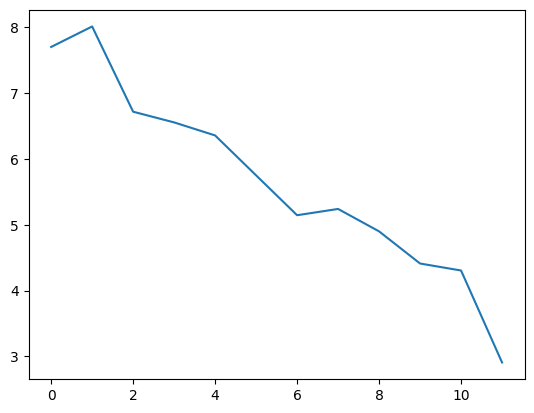

In [42]:
chg.z.plot()

In [43]:
pd.read_sql("SELECT max(week) FROM projections WHERE year=2025", engine)

,max(week)
0,12


### Weekly Sit or Start Decisions

In [18]:
current_period

12

In [19]:
ids = fp.load_id_map()

In [20]:
eligibility_url_dict.keys()

dict_keys(['9 Grand Kids', 'Brewbirds', 'Charmer', 'Dirty Birds', 'Harveys Wallbangers', 'Lil Trump & the Ivanabees', 'Lima Time', 'Roid Ragers', 'Trouble with the Curve', 'Ugly Spuds', 'Wiscompton Wu-Tang', 'Young Guns', "Mom's Cookin"])

In [21]:
# 
for key, val in eligibility_url_dict.items():
    print(val, key)
    if val in ['30', '3', '36', '41', '4', '38', '44', '1', '29', '42', '45', '47']:
        try:
            #data = get_weekly_sit_or_start_by_owner(key, val, ids, current_period-1, current_period) # Only the most recent completed week
            data = get_weekly_sit_or_start_by_owner(key, val, ids, 1, current_period) # Start from week 1
            if data.shape[0] > 0:
                data = data.drop_duplicates('cbsid')
                data['decision'] = data['Decision'].apply(lambda x: x.lower()) #.rename(columns={'Decision':'decision'})
                data[data['week']==current_period-1][['cbsid', 'owner_id', 'year', 'week', 'pos', 'decision']]\
                    .to_sql('roster', con=engine, if_exists='append', index=False)
        except:
            print(f"There was an error processing {val}")

30 9 Grand Kids
3 Brewbirds
36 Charmer
41 Dirty Birds
4 Harveys Wallbangers
27 Lil Trump & the Ivanabees
38 Lima Time
44 Roid Ragers
1 Trouble with the Curve
29 Ugly Spuds
42 Wiscompton Wu-Tang
45 Young Guns
47 Mom's Cookin


In [22]:
# Read in sit start csv data
# Don't need to run this all the time

data_list = []
for key, val in eligibility_url_dict.items():
    #print(val, key)
    if val!='27':
        data_list.append(pd.read_excel(f"data\\{datetime.now().year}-{key}-sit-start.xlsx"))
sit_start = pd.concat(data_list)
sit_start = sit_start[sit_start['week']==current_period-1].drop_duplicates()
sit_start['Decision'] = sit_start['Decision'].apply(lambda x: x.lower())
sit_start.rename(columns={'Decision':'decision'},inplace=True)
sit_start

,CBSNAME,Owner,week,Team,pos,decision,cbsid,MLBID,IDFANGRAPHS,year,owner_id
330,Salvador Perez,9 Grand Kids,11,KC,C,start,1793168,521692.0,7304,2025,30
331,Wilmer Flores,9 Grand Kids,11,SF,1B,start,1665897,527038.0,5827,2025,30
332,Ozzie Albies,9 Grand Kids,11,ATL,2B,start,2167464,645277.0,16556,2025,30
333,Daniel Schneemann,9 Grand Kids,11,CLE,3B,start,3107152,682177.0,25180,2025,30
334,Francisco Lindor,9 Grand Kids,11,NYM,SS,start,1894627,596019.0,12916,2025,30
...,...,...,...,...,...,...,...,...,...,...,...
358,Yu Darvish,Mom's Cookin,11,SD,SP,sit,1937347,506433.0,13074,2025,47
359,Brady Singer,Mom's Cookin,11,CIN,SP,sit,2942978,663903.0,25377,2025,47
360,Raisel Iglesias,Mom's Cookin,11,ATL,RP,sit,2135575,628452.0,17130,2025,47
361,Luke Jackson,Mom's Cookin,11,TEX,RP,sit,1765054,592426.0,11752,2025,47


In [25]:
#### STOP ####
# This code adds to roster table. If the previous cell worked, you won't need to do this
sit_start[['cbsid', 'owner_id', 'year', 'week', 'pos', 'decision']]\
    .to_sql('roster', con=engine, if_exists='append', index=False)

397

In [26]:
pd.pivot_table(pd.read_sql(f"SELECT * FROM roster WHERE year=2025", engine), index='owner_id', columns='week', aggfunc='count', values='cbsid')

week,1,2,3,4,5,6,7,8,9,10,11
owner_id,,,,,,,,,,,
1,33,33,33,33,33,33,33,33,33,33,33
3,33,33,33,33,33,33,33,33,33,33,33
4,33,33,33,34,33,33,33,33,34,34,34
29,33,33,33,33,33,33,33,33,33,33,33
30,33,33,33,33,33,33,33,33,33,33,33
36,33,33,33,33,33,33,33,33,33,33,33
38,33,33,33,33,33,33,33,33,33,33,33
41,33,33,33,33,33,33,33,33,33,33,33
42,33,33,33,33,34,34,34,34,33,33,33


#### Database fix code snippets

In [24]:
# If you need to delete all of the data from roster in a certain year, you can use this
conn = sqlite3.connect('fantasy_data.db')

# Create a cursor object
cursor = conn.cursor()

# Execute the ALTER TABLE command
cursor.execute('DELETE FROM roster WHERE year=2025 and week=11')
#cursor.execute('DELETE FROM stats WHERE year=2025')

# Commit the changes
conn.commit()

In [18]:
conn = sqlite3.connect('fantasy_data.db')
stmt = "UPDATE roster SET week=1 WHERE year=2025"
cursor = conn.cursor()
cursor.execute(stmt)
conn.commit()

In [50]:
stmt = "UPDATE roster SET decision='sit' WHERE decision='Sit'"
cursor = conn.cursor()
cursor.execute(stmt)

stmt = "UPDATE roster SET decision='start' WHERE decision='Start'"
cursor = conn.cursor()
cursor.execute(stmt)

conn.commit()

AttributeError: 'Engine' object has no attribute 'cursor'

In [49]:
dups = pd.read_sql(f"SELECT cbsid, count(*) Count FROM roster WHERE year=2024 AND week={current_period-1} GROUP BY cbsid HAVING count(*)>1", engine)
dups.sort_values('cbsid')

,cbsid,Count


In [61]:
pd.read_sql(f"SELECT * FROM roster WHERE year=2025 AND cbsid=2901324", engine)

,cbsid,owner_id,year,week,pos,decision
0,2901324,36,2025,1,DH,start
1,2901324,36,2025,2,DH,start
2,2901324,36,2025,3,DH,start
3,2901324,36,2025,4,DH,start
4,2901324,36,2025,5,DH,start


In [52]:
",".join([str(v) for v in list(dups.cbsid.unique())])

''

In [48]:
pd.read_sql(f"SELECT * FROM roster WHERE year=2024 AND week={current_period-1} AND cbsid IN ({','.join([str(v) for v in list(dups.cbsid.unique())])}) ORDER BY cbsid", engine)['owner_id'].unique()

array([36], dtype=int64)

In [ ]:
# Get all of Ohtani's stats
ohtani_stats = pd.read_sql("SELECT * FROM stats WHERE cbsid=2901324 and year=2025 AND AB IS NOT NULL ORDER BY week", conn).drop_duplicates()
# Set the pitching stats to NULL
ohtani_stats.loc[:, ['QS', 'SO','SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']] = None
params = ohtani_stats.to_dict(orient='records')
# Delete his stats from the table
cursor = conn.cursor()
stmt = "DELETE FROM stats WHERE year=2025 AND cbsid=2901324"
cursor.execute(stmt)
conn.commit()
# Insert the stats back into the table
stmt = "INSERT INTO stats (cbsid, year, week, R, RBI, HR, SB, H, AB, QS, SO, SvHld, ER, Ha, BBa, IP, outs) VALUES (:cbsid, :year, :week, :R, :RBI, :HR, :SB, :H, :AB, :QS, :SO, :SvHld, :ER, :Ha, :BBa, :IP, :outs)"
for param in params:
    cursor.execute(stmt, param)
conn.commit()

In [101]:
# Delete statement

# Create an engine
engine = create_engine('sqlite:///fantasy_data.db', echo=False)

# Using a connection with a transaction context manager
with engine.connect() as connection:
    # Begin a transaction explicitly
    with connection.begin() as transaction:
        #delete_statement = text("DELETE FROM roster WHERE year=:year AND week>=:week")
        #delete_statement = text("DELETE FROM projections WHERE week=:week AND year=:year AND proj_type=:proj_type")
        #delete_statement = text("DELETE FROM stats WHERE year=:year AND week=:week")
        #delete_statement = text("DELETE FROM roster WHERE year=:year AND week=:week AND cbsid=:cbsid")
        insert_statement = text("INSERT INTO roster (cbsid, owner_id, year, week, pos, decision) VALUES (2901324, 36, 2024, 23, 'DH', 'start')")
        #update_statement = text("UPDATE roster SET decision='start' WHERE decision='Start'")
        #connection.execute(update_statement)
        #esult = connection.execute(delete_statement, {'year': 2024, 'week': 23, 'proj_type':'ros', 'cbsid':2901324})
        result = connection.execute(insert_statement)
        # Transaction is committed or rolled back automatically at the end of the context block


In [377]:
with engine.connect() as connection:
    with connection.begin() as transaction:
        connection.execute(text("ALTER TABLE stats ADD QS INTEGER"))
        #connection.execute(text("DELETE FROM roster WHERE year=2024"))
        #connection.execute(text("DELETE FROM eligibility WHERE year=2024 and week=17"))

In [280]:
pd.read_sql("SELECT * FROM projections WHERE week=1 and year=2025 and proj_type='ros'", engine)

,cbsid,year,week,proj_type,AB,R,H,HR,RBI,BB,SB,BA,IP,W,SO,Sv+Hld,BBa,Ha,ERA,WHIP,ER,z,QS
0,2901324,2025,1,ros,546.0,125.0,172.0,44.0,117.0,72.0,45.0,0.315,98.0,None,117.0,0.0,28.0,75.0,3.49,1.05,38.002222,15.392098,10
1,2071264,2025,1,ros,521.0,112.0,162.0,49.0,126.0,106.0,8.0,0.311,0.0,None,0.0,NaN,0.0,0.0,0.00,0.00,0.000000,11.758351,0
2,3117472,2025,1,ros,578.0,112.0,195.0,31.0,100.0,56.0,28.0,0.337,0.0,None,0.0,NaN,0.0,0.0,0.00,0.00,0.000000,11.775972,0
3,2044495,2025,1,ros,553.0,102.0,161.0,36.0,106.0,61.0,34.0,0.291,0.0,None,0.0,NaN,0.0,0.0,0.00,0.00,0.000000,9.909423,0
4,1894627,2025,1,ros,582.0,111.0,164.0,33.0,96.0,63.0,28.0,0.282,0.0,None,0.0,NaN,0.0,0.0,0.00,0.00,0.000000,8.408697,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,26912443,2025,1,ros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,None,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,-4.888924,0
544,26912463,2025,1,ros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,None,0.0,NaN,0.0,0.0,0.00,0.00,0.000000,-11.606552,0
545,2507361,2025,1,ros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,None,0.0,NaN,0.0,0.0,0.00,0.00,0.000000,-11.606552,0
546,1893753,2025,1,ros,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,None,0.0,0.0,0.0,0.0,0.00,0.00,0.000000,-4.888924,0


### Weekly Stats
Begin loop code

In [27]:
def fill_pos(row):
    for pos in row['Pos'].split('/'):
        print(pos)
        data.loc[data['cbsid']==row['cbsid'], pos] = 5
    return row

In [28]:
stat_type = 'h'

In [33]:
wk = pd.read_sql("SELECT MAX(week) wk FROM stats WHERE year=2025",engine).iloc[0]['wk']
if not wk:
    wk = current_period - 1

wk, stat_type

(10, 'p')

In [34]:
#wk = 2

In [35]:
yr = datetime.now().year
df = pd.DataFrame()

if stat_type == 'h':
    # hitting
    driver.get(f'https://xdl.baseball.cbssports.com/stats/stats-main/all:C:1B:2B:3B:SS:MI:CI:OF:DH/period-{wk+1}:p/standard/stats?print_rows=9999')
else:
    # pitching
    driver.get(f'https://xdl.baseball.cbssports.com/stats/stats-main/all:SP:RP/period-{wk+1}:p/standard/stats?print_rows=9999')

wk += 1
html = driver.page_source
soup = bs4(html, 'html.parser')
data = pd.read_html(str(soup.find_all('table')))[0]
data.columns = data.columns.droplevel()
data['cbsid'] = data.Action.apply(lambda txt: -1 if len(re.findall(r'\b\d{5,}\b', txt))==0 else re.findall(r'\b\d{5,}\b', txt)[0])
data['cbsid'] = data.cbsid.astype(int)
data = data.iloc[:-1, 1:]
data['Rank'] = data['Rank'].astype(int)
data = data[(data['Avail']!='FA') | (data['Rank']<9999)]
try:
    data['Team'] = data.Player.apply(lambda x: x.split()[-1])
except:
    pass
try:
    data['Player'] = data.Player.apply(lambda x: ' '.join(x.split()[:-3]))
except:
    pass
data['Week'] = wk
#id_dict = {int(i['href'].split('/')[-1]):[i.text, i['aria-label'].split(' ')[-1]] for i in soup.find_all("a", {"class": "playerLink"}, href=True) if i.text!=''}
#id_df = pd.DataFrame(id_dict, index=['CBSNAME', 'Team']).T
#data = data.merge(id_df.reset_index(), left_on=['Player', 'Team'], right_on=['CBSNAME', 'Team'], how='left')

df = pd.concat([df,data])

df.rename(columns={'Avail':'Owner', 'Week':'week'},inplace=True)
df = df.replace(name_change)
df['year'] = yr

if stat_type == 'h':
    try:
        dfh = pd.read_excel(f'data//{yr}-weekly-stats-h.xlsx')
        dfh.fillna(0,inplace=True)
    except:
        pass

    if wk > 1:
        pd.concat([dfh,df[['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB']]]).sort_values('week')\
            .to_excel(f'data//{yr}-weekly-stats-h.xlsx', index=False)
    else:
        df[['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB']].sort_values('week')\
            .to_excel(f'data//{yr}-weekly-stats-h.xlsx', index=False)
else:
    df['ERA'] = df['ERA'].astype(float)
    df['outs'] = df.INNs.astype(float).apply(lambda x: (int(str(x).split('.')[0])*3) + int(str(x).split('.')[1]))
    df['IP'] = round(df['outs']/3.,2)
    df['ER'] = df.apply(lambda x: round(x['ERA']*x['IP']/9.,1) if x['outs']>0 else 0, axis=1)
    df['SvHld'] = df['S'].astype(int)+df['HD'].astype(int)
    df.rename(columns={'K':'SO', 'H':'Ha', 'BB':'BBa'}, inplace=True)

    try:
        dfp = pd.read_excel(f'data/{yr}-weekly-stats-p.xlsx')
        dfp.fillna(0,inplace=True)
        dfp['SvHld'] = dfp['SvHld'].astype(int)
    except:
        pass

    if wk > 1:
        pd.concat([dfp.rename(columns={'SvHLD':'SvHld'}),df[['cbsid', 'year', 'week', 'QS', 'SO', 'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']]])\
            .to_excel(f'data//{yr}-weekly-stats-p.xlsx', index=False)
    else:
        df[['cbsid', 'year', 'week', 'QS', 'SO', 'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']]\
            .to_excel(f'data//{yr}-weekly-stats-p.xlsx', index=False)

In [32]:
stat_type = 'p'
# run this cell then run the previous 2 again

In [36]:
dfh = pd.read_excel(f'data//{datetime.now().year}-weekly-stats-h.xlsx')
dfh.fillna(0,inplace=True)
dfp = pd.read_excel(f'data//{datetime.now().year}-weekly-stats-p.xlsx')
dfp.fillna(0,inplace=True)

df = dfh.merge(dfp, on='cbsid', suffixes=['', '_p'], how='outer')
df['year'].fillna(datetime.now().year,inplace=True)
df['week'].fillna(df['week_p'], inplace=True)
df.drop(columns=['year_p', 'week_p'],inplace=True)

In [37]:
df[df['week'].isin([wk])][['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB', 'QS', 'SO',
       'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']].duplicated('cbsid').sum()

10

In [38]:
df = df.sort_values(['week', 'AB','outs'], ascending=[True, False, False]).drop_duplicates()

In [39]:
s = df[df['week'].isin([wk])].duplicated(keep=False)
df[df.index.isin(s[s].index)]

,cbsid,year,week,R,RBI,HR,SB,H,AB,QS,SO,SvHld,ER,Ha,BBa,IP,outs


In [40]:
df[df['cbsid']==2223750]

,cbsid,year,week,R,RBI,HR,SB,H,AB,QS,SO,SvHld,ER,Ha,BBa,IP,outs
4511,2223750,2025.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,0.0,0.0,0.0,1.00,3.0
4512,2223750,2025.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,2.0,4.0,0.0,2.00,6.0
4513,2223750,2025.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,2.0,1.0,2.0,0.0,3.00,9.0
4514,2223750,2025.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,2.0,0.0,0.0,0.0,2.00,6.0
4515,2223750,2025.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,4.0,0.0,6.0,0.0,4.00,12.0
4516,2223750,2025.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,0.0,1.0,1.0,0.0,2.00,6.0
4517,2223750,2025.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,1.0,0.0,1.0,0.0,2.00,6.0
4518,2223750,2025.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,2.0,0.0,0.0,1.0,3.67,11.0
4519,2223750,2025.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,0.0,0.0,0.0,0.0,1.00,3.0
4520,2223750,2025.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4.0,1.0,5.0,7.0,1.0,3.00,9.0


In [41]:
wk

11

In [42]:
# Upload to stats table

#df[(df['week'].isin([wk])) & (df['AB']>=0)]
df[(df['week'].isin([wk]))][['cbsid', 'year', 'week', 'R', 'RBI', 'HR', 'SB', 'H', 'AB', 'QS', 'SO', 'SvHld', 'ER', 'Ha', 'BBa', 'IP', 'outs']]\
    .to_sql('stats', if_exists='append', con=engine, index=False)

882

In [43]:
pd.read_sql('SELECT s.* FROM stats s WHERE s.year=2025 ORDER BY s.cbsid, s.week', engine)

,cbsid,year,week,R,RBI,HR,SB,H,AB,W,SO,SvHld,ER,Ha,BBa,IP,outs,QS
0,530362,2025,1,NaN,NaN,NaN,NaN,NaN,NaN,None,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0
1,530362,2025,2,NaN,NaN,NaN,NaN,NaN,NaN,None,5.0,0.0,2.0,6.0,1.0,5.00,15.0,0.0
2,530362,2025,3,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,0.0,3.0,5.0,2.0,2.33,7.0,0.0
3,530362,2025,4,NaN,NaN,NaN,NaN,NaN,NaN,None,9.0,0.0,5.0,5.0,3.0,5.67,17.0,0.0
4,530362,2025,5,NaN,NaN,NaN,NaN,NaN,NaN,None,7.0,0.0,5.0,10.0,5.0,11.67,35.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8874,29710712,2025,5,NaN,NaN,NaN,NaN,NaN,NaN,None,2.0,0.0,0.0,1.0,0.0,2.33,7.0,0.0
8875,29710712,2025,8,NaN,NaN,NaN,NaN,NaN,NaN,None,1.0,0.0,1.0,3.0,1.0,2.00,6.0,0.0
8876,29710712,2025,9,NaN,NaN,NaN,NaN,NaN,NaN,None,3.0,0.0,0.0,6.0,1.0,6.00,18.0,0.0
8877,29710712,2025,10,NaN,NaN,NaN,NaN,NaN,NaN,None,1.0,0.0,0.0,2.0,1.0,2.00,6.0,0.0


In [104]:
# If you need to delete all of the data from roster in a certain year, you can use this
conn = sqlite3.connect('fantasy_data.db')

# Create a cursor object
cursor = conn.cursor()

# Execute the ALTER TABLE command
#cursor.execute('DELETE FROM roster WHERE year=2025 and week=4')
#cursor.execute('DELETE FROM stats WHERE year=2025 and week=3')

# Commit the changes
conn.commit()